In [152]:
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm

In [153]:
'''
Sample from the power distribution between
k_min <= X <= k_max with exponent of value 
"exponent"
'''
def power_distribution(size=None, exponent=2.5, k_min=1, k_max=1000):
    F = np.random.random(size)

    return (F * (k_max**(1-exponent) - k_min**(1-exponent)) + k_min**(1-exponent))**(1/(1-exponent))

'''
Create graph (as an adjacency matrix) of the
power law degree distribution. The graph is 
created using metropolis alogirthm.
'''
def metropolis_power_dist(N=1000, iterations=1e4, exponent=2.5, k_min=1, k_max=1000):
    N = int(N)
    iterations = int(iterations)
    matrix = np.zeros((N, N))
    k = power_distribution(N, exponent, k_min, k_max)
    k_mean = np.mean(k)
    
    for _ in tqdm(range(iterations)):
        i, j = np.random.randint(N, size=(2, N))
        while not np.all(i!=j):
            j[i==j] = np.random.randint(N, size=np.sum(i==j))

        p = np.random.rand(N)
        p_ij = k[i]*k[j] / (k_mean*N)
        indx = p < p_ij
        for indx, i, j in zip(indx, i, j):
            if indx:
                matrix[i,j] = 1
                matrix[j,i] = 1
            else:
                matrix[i,j] = 0
                matrix[j,i] = 0
        
    return matrix

In [154]:
'''
Generate two networks: physical and virtual.
Virtual network is the same network as the
physical one (with the same connections), but it 
has additional 400 random links between agents.
'''
nodes = 1250

physical = nx.from_numpy_matrix(metropolis_power_dist(N=nodes, iterations=1e4, exponent=2.5, k_min=1, k_max=nodes))
# Remove nodes without neighbors
zero_neighbors_nodes = [n for n in physical if physical.degree(n) == 0]
physical.remove_nodes_from(zero_neighbors_nodes)

virtual = physical.copy()

for _ in range(400):
    nodeA, nodeB = np.random.choice(virtual.nodes, 2, replace=False)
    while nodeB in virtual.neighbors(nodeA):
        nodeA, nodeB = np.random.choice(virtual.nodes, 2, replace=False)
    virtual.add_edge(nodeA, nodeB)

'''
Initialize agents randomly with certain percentages
of beign infected or aware
'''
aware_percentage = 0.
infected_percentage = 0.2
for n in physical:
    infect_rnd, aware_rnd = np.random.random(size=2)
    
    if infect_rnd <= infected_percentage:
        physical.nodes[n]['infected'] = True
    else:
        physical.nodes[n]['infected'] = False

    if aware_rnd <= aware_percentage or physical.nodes[n]['infected']:
        virtual.nodes[n]['aware'] = True
    else:
        virtual.nodes[n]['aware'] = False

print(f'Number of nodes in network: {physical.number_of_nodes()}')
print(f'Number of edges in physical network: {physical.number_of_edges()}')
print(f'Number of edges in virtual network: {virtual.number_of_edges()}')
print(f'Number of infected nodes: {sum([physical.nodes[n]["infected"] for n in physical])} ({sum([physical.nodes[n]["infected"] for n in physical]) / physical.number_of_nodes() * 100:.2f}%)')
print(f'Number of aware nodes: {sum([virtual.nodes[n]["aware"] for n in virtual])} ({sum([virtual.nodes[n]["aware"] for n in virtual]) / virtual.number_of_nodes() * 100:.2f}%)')

100%|██████████| 10000/10000 [00:13<00:00, 732.62it/s]


Number of nodes in network: 1029
Number of edges in physical network: 1915
Number of edges in virtual network: 2315
Number of infected nodes: 208 (20.21%)
Number of aware nodes: 208 (20.21%)


100%|██████████| 125000/125000 [00:02<00:00, 53154.51it/s]

0.3177842565597668
0.1661807580174927


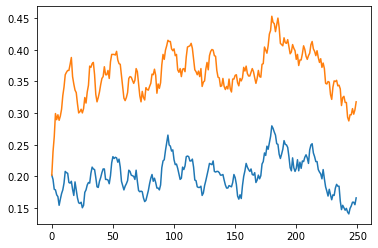

In [155]:
Lambda = 0.15 # probability of becoming aware
delta = 0.6   # probability of becoming unaware
beta = 0.3    # probability of infection
gamma = 0     # factor reducing the likelihood of infection
mu = 0.4      # probability of recovery

plot_aware = []
plot_infected = []
i = 0

iterations = 100
for node in tqdm(np.random.choice(physical.nodes, size=nodes*iterations)):
    # AI
    if physical.nodes[node]['infected']:
        # AI -> UI
        if random.random() < delta:
            # AI -> UI -> US
            if random.random() < mu:
                physical.nodes[node]['infected'] = False
                virtual.nodes[node]['aware'] = False

        # AI -> AI
        else:
            # AI -> AI -> AS
            if random.random() < mu:
                physical.nodes[node]['infected'] = False
            
    # AS
    elif virtual.nodes[node]['aware']:
        # AS -> US
        if random.random() < delta:
            any_infected_neighbor = any([physical.nodes[n]['infected'] for n in physical.neighbors(node)])
            # AS -> US -> UI -> AI
            if any_infected_neighbor and random.random() < beta:
                physical.nodes[node]['infected'] = True
            # AS -> US -> US
            else:
                virtual.nodes[node]['aware'] = False

        # AS -> AS
        else:
            any_infected_neighbor = any([physical.nodes[n]['infected'] for n in physical.neighbors(node)])
            # AS -> AS -> AI
            if any_infected_neighbor and random.random() < gamma*beta:
                physical.nodes[node]['infected'] = True


    # US
    else:
        any_aware_neighbor = any([virtual.nodes[n]['aware'] for n in virtual.neighbors(node)])
        # US -> AS
        if any_aware_neighbor and random.random() < Lambda:
            virtual.nodes[node]['aware'] = True
            any_infected_neighbor = any([physical.nodes[n]['infected'] for n in physical.neighbors(node)])
            # US -> AS -> AI
            if any_infected_neighbor and random.random() < gamma*beta:
                physical.nodes[node]['infected'] = True

        # US -> US
        else:
            any_infected_neighbor = any([physical.nodes[n]['infected'] for n in physical.neighbors(node)])
            # US -> US -> UI -> AI
            if any_infected_neighbor and random.random() < beta:
                physical.nodes[node]['infected'] = True
                virtual.nodes[node]['aware'] = True
                
    if not i % 500:
        aware = [virtual.nodes[n]['aware'] for n in virtual]
        infected = [physical.nodes[n]['infected'] for n in physical]
        plot_aware.append(sum(aware)/len(aware))
        plot_infected.append(sum(infected)/len(infected))
    i += 1

print(sum(aware)/len(aware))
print(sum(infected)/len(infected))
plt.plot(plot_infected)
plt.plot(plot_aware)